In [0]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import math
import csv
from google.colab import files
from collections import deque

In [2]:
uploaded = files.upload()

Saving mnist.csv to mnist.csv


In [4]:
file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)   #10000개
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
train_image  = np.empty((size_row * size_col, 1000), dtype=float)
train_label  = np.empty(1000, dtype=int)
test_image  = np.empty((size_row * size_col, 9000), dtype=float)
test_label  = np.empty(9000, dtype=int)

for line in data:
    if count < 1000 :
      line_data   = line.split(',')
      label       = line_data[0]
      im_vector   = np.asfarray(line_data[1:])
      im_vector   = normalize(im_vector)

      train_label[count]       = label       # size : 10000
      train_image[:, count]    = im_vector   # size : 784 * 10000

    else: 
      line_data   = line.split(',')
      label       = line_data[0]
      im_vector   = np.asfarray(line_data[1:])
      im_vector   = normalize(im_vector)

      test_label[count-1000]       = label       # size : 10000
      test_image[:, count-1000]    = im_vector   # size : 784 * 10000

    count += 1

train_costs = deque()
test_costs = deque()
theta_0s = deque()
theta_1s = deque()
theta_2s = deque()
bias_0s = deque()
bias_1s = deque()
bias_2s = deque()
iters = deque()
train_accuracys = deque()
test_accuracys = deque()
incorrect_predicts = deque()

#correct_labels = []
correct_labels = deque()
#incorrect_labels = []
incorrect_labels = deque()

print(num_image)  #10000
print(len(train_image))  #784
print(len(train_image[0]))  #6000
print(len(train_label))  #6000
print(len(test_image))  #784
print(len(test_image[0]))  #4000
print(len(test_label))  #4000
#list_label 0~5999까지 training data, 6000~9999까지 test data
#list_image [:,5999]까지 training data, [:,9999]까지 test data

10000
784
1000
1000
784
9000
9000


In [0]:
def forward(theta, value):
  #print(theta.shape, value.shape)
  #print("Theta", theta.shape)
  #print("value", value.shape)
  result = np.matmul(theta, value)
  return result

In [0]:
def sigmoid(value):
  """
  length = len(value)
  for i in range(0, length):
    value[i] = 1 / (1 + np.exp(-value[i]))
  """
  value = value.astype(float)
  value = np.multiply(value,-1)
  value = np.exp(value)
  value = np.add(1,value)
  value = np.divide(1, value)
  return value

In [0]:
def addBias(value, bias):
  """
  length = len(bias)
  for i in range(0, length):
    value[i] += bias[i]
  """
  value = np.add(value, bias)
  return value

In [0]:
def neuralNet(x, u, v, w, bias0, bias1, bias2):    #data, theta0, theta1, theta2, bias0, bias1, bias2
  y_hat = forward(u, x)
  y_hat = addBias(y_hat, bias0)
  y = sigmoid(y_hat)
  z_hat = forward(v, y)
  z_hat = addBias(z_hat, bias1)
  z = sigmoid(z_hat)
  h_hat = forward(w, z)
  h_hat = addBias(h_hat, bias2)
  h = sigmoid(h_hat)
  return y, z, h

In [0]:
def objectiveFunction(image, label, theta0, theta1, theta2, b0, b1, b2):     #list_image[:, count], list_label -> traing과 test 구분해야겠다.!!
  length = len(label)                    #두는 이유는 trainig 6000, test 4000개  갯수가 달라서
  cost = 0
  for i in range(0, length):
    y, z, outputs = neuralNet(image[:,i], theta0, theta1, theta2, b0, b1, b2)  #size = 10x1 good!!!
    l = label[i]
    #print("outputs",outputs)
    temp7 = np.log(outputs)
    #print("log",temp7)
    temp8 = np.subtract(1, outputs)
    temp8 = np.log(temp8)
    cost1 = -temp7[l] - np.sum(temp8) + temp8[l]
    #print(-temp7[l], temp8[l])
    cost += cost1
    cost /= length
  print(cost)
  
  return cost

In [0]:
def gradientDescent(image, label, theta0, theta1, theta2, b0, b1, b2, learning_rate):
  lr = learning_rate
  length = len(label)
  for i in range(0, length):
    x = image[:,i]
    y, z, h = neuralNet(image[:,i], theta0, theta1, theta2, b0, b1, b2)
    l = label[i]

    ##first layer
    temp1 = np.zeros(10)
    temp1 = np.subtract(h, l)
    temp = np.multiply(temp1, lr/length)
    b2 = np.subtract(b2, temp)

    z_transpose = np.reshape(z, (1,49))
    temp1 = np.reshape(temp1, (10,1))
    temp2 = np.zeros((10,49))
    temp2 = np.matmul(temp1, z_transpose)
    temp = np.multiply(temp2, lr/length)
    theta2 = np.subtract(theta2, temp)
    
    ##second layer
    temp3 = np.zeros(49)
    temp1 = np.subtract(h, l)                 #그전의 temp1을 가져와서 썼더니, 차원 size forward matmul에서 차원이 틀려서 안됨!
    temp3 = np.matmul(temp1, theta2)
    temp3 = np.multiply(temp3, z)
    temp3 = np.multiply(temp3, 1-z)
    temp = np.multiply(temp3, lr/length)
    b1 = np.array(np.subtract(b1, temp), dtype=object)

    temp4 = np.zeros((49,196))
    temp3 = np.reshape(temp3, (49,1))
    y_transpose = np.reshape(y, (1,196))
    #print(temp3.shape)
    #print(y_transpose.shape)
    temp4 = np.matmul(temp3, y_transpose)
    temp = np.multiply(temp4, lr/length)        ##***********이거 안넣었다
    theta1 = np.array(np.subtract(theta1, temp), dtype=object)

    ##third layer
    temp5 = np.zeros(196)
    temp1 = np.subtract(h, l)
    temp5 = np.matmul(temp1, theta2)
    temp5 = np.multiply(temp5, z)
    temp5 = np.multiply(temp5, 1-z)
    theta1 = np.reshape(theta1, (49, 196))
    temp5 = np.matmul(temp5, theta1)
    temp5 = np.multiply(temp5, y)
    temp5 = np.multiply(temp5, 1-y)
    temp = np.multiply(temp5, lr/length)
    b0 = np.array(np.subtract(b0, temp), dtype=object)

    temp6 = np.zeros((196, 784))
    temp5 = np.reshape(temp5, (196,1))
    x_transpose = np.reshape(x, (1,784))
    #print(temp3.shape)
    #print(y_transpose.shape)
    temp6 = np.matmul(temp5, x_transpose)
    temp = np.multiply(temp6, lr/length)        ##***********이거 안넣었다
    theta0 = np.array(np.subtract(theta0, temp), dtype=object)

  #print("b2.shape",b2.shape)
  #print("b1.shape",b1.shape)
  #print("b0.shape",b0.shape)
  #print("theta2.shape",theta2.shape)
  #print("theta1.shape",theta1.shape)
  #print("theta0.shape",theta0.shape)
  return b2, theta2, b1, theta1, b0, theta0

"""  



    ## first layer update
    for j in range(0, 10):
      estimate1 = (-label[i] + h[j])
      b2[j] -= lr * estimate1       #bias2 update!
      
      for k in range(0, 49):
        estimate2 = estimate1 * z[k]
        theta2[j][k] -= lr * estimate2   #theta2 update!
    
    ## second layer update
    for l in range(0, 196):
      for j in range(0, 49):
        estimate3 = 0
        for k in range(0, 10):
          estimate3 += (-label[i] + h[k]) * theta1[k][j]
        b1[j] -= lr * z[j] * (1 - z[j]) * estimate3
        theta1[j][l] -= b1[j] * y[l]
"""

'  \n\n\n\n    ## first layer update\n    for j in range(0, 10):\n      estimate1 = (-label[i] + h[j])\n      b2[j] -= lr * estimate1       #bias2 update!\n      \n      for k in range(0, 49):\n        estimate2 = estimate1 * z[k]\n        theta2[j][k] -= lr * estimate2   #theta2 update!\n    \n    ## second layer update\n    for l in range(0, 196):\n      for j in range(0, 49):\n        estimate3 = 0\n        for k in range(0, 10):\n          estimate3 += (-label[i] + h[k]) * theta1[k][j]\n        b1[j] -= lr * z[j] * (1 - z[j]) * estimate3\n        theta1[j][l] -= b1[j] * y[l]\n'

In [0]:
def checkAccuracy(image, label, theta0, theta1, theta2, b0, b1, b2):
  length = len(label)
  count = 0
  for i in range(0, length):
    y, z, h = neuralNet(image[:,i], theta0, theta1, theta2, b0, b1, b2)
    if label[i] == np.argmax(h):
      count += 1
  accuracy = count / length
  return accuracy

In [0]:
def checkCorrect(image, label, theta0, theta1, theta2, b0, b1, b2):
  length = len(label)
  count = 0
  labels = []
  for i in range(0, length):
    if count == 10:
      break
    else:
      y, z, h = neuralNet(image[:,i], theta0, theta1, theta2, b0, b1, b2)
      if label[i] == np.argmax(h):
        labels.append(i)  #index를 labels 리스트에 추가
        count += 1
  return labels

In [0]:
def checkIncorrect(image, label, theta0, theta1, theta2, b0, b1, b2):
  length = len(label)
  count = 0
  labels = []
  predicts = []
  for i in range(0, length):
    if count == 10:
      break
    else:
      y, z, h = neuralNet(image[:,i], theta0, theta1, theta2, b0, b1, b2)
      if label[i] != np.argmax(h):
        labels.append(i)  #index를 labels 리스트에 추가
        count += 1
        predicts.append(np.argmax(h))
  return labels, predicts

In [0]:
def main():
  mu = 0
  sigma = 0.1

  theta_0 = np.random.normal(mu, sigma, size=(196,784))   #size = 196x784
  theta_1 = np.random.normal(mu, sigma, size=(49,196))    #size = 49x196
  theta_2 = np.random.normal(mu, sigma, size=(10,49))     #size = 10x49
  
  b_0 = np.random.normal(mu, sigma, 196)                  #size = 196x1
  b_1 = np.random.normal(mu, sigma, 49)                   #size = 49x1
  b_2 = np.random.normal(mu, sigma, 10)                   #size = 10x1

  lr = 0.001                                                #learning rate

  #training step
  for iter in range(0, 30):
    iters.append(iter)
    train_cost = objectiveFunction(train_image, train_label, theta_0, theta_1, theta_2, b_0, b_1, b_2)  #print(cost)
    print("##########################################111111111111111111111111111111",iter)
    train_costs.append(train_cost)
    b_2, theta_2, b_1, theta_1, b_0, theta_0 = gradientDescent(train_image, train_label, theta_0, theta_1, theta_2, b_0, b_1, b_2, lr)
    
    #############train accuracy 하자!############
    train_accuracy = checkAccuracy(train_image, train_label, theta_0, theta_1, theta_2, b_0, b_1, b_2)
    train_accuracys.append(train_accuracy)
    print("##########################################12222222222")

    test_cost = objectiveFunction(test_image, test_label, theta_0, theta_1, theta_2, b_0, b_1, b_2)
    print("##########################################33333333333")
    test_costs.append(test_cost)
    #############test accuracy
    test_accuracy = checkAccuracy(test_image, test_label, theta_0, theta_1, theta_2, b_0, b_1, b_2)
    test_accuracys.append(test_accuracy)

    #train_y, train_z, train_h = neuralNet(train_image, theta_0, theta_1, theta_2, b_0, b_1, b_2) #image 문제
    print("##########################################4444444444444444444")

    
  ######correct label 가져오자!
  #correct_labels = checkCorrect(test_image, test_label, theta_0, theta_1, theta_2, b_0, b_1, b_2)  #data의 index만 헐당!
  correct_label = checkCorrect(test_image, test_label, theta_0, theta_1, theta_2, b_0, b_1, b_2)
  correct_labels.append(correct_label)
  #incorrect_labels = checkIncorrect(test_image, test_label, theta_0, theta_1, theta_2, b_0, b_1, b_2)
  incorrect_label, predict = checkIncorrect(test_image, test_label, theta_0, theta_1, theta_2, b_0, b_1, b_2)
  incorrect_labels.append(incorrect_label)
  incorrect_predicts.append(predict)

  print("iters",iters)
  print("train_costs",train_costs)
  print("Plotting the loss curve")
  fig = plt.figure()
  graph1 = plt.plot(iters, train_costs, 'b')
  graph2 = plt.plot(iters, test_costs, 'r')
  plt.xlabel('iterations')
  plt.ylabel('loss')
  plt.show()

if __name__ == "__main__":
  main()

0.001230377217345988
##########################################111111111111111111111111111111 0
##########################################12222222222
0.001825587122277367
##########################################33333333333
##########################################4444444444444444444
0.0012787073583023104
##########################################111111111111111111111111111111 1
##########################################12222222222
0.0019005240571844991
##########################################33333333333
##########################################4444444444444444444
0.0013287508842587312
##########################################111111111111111111111111111111 2
##########################################12222222222
0.0019780400602736397
##########################################33333333333
##########################################4444444444444444444
0.0013805579385253264
##########################################111111111111111111111111111111 3
######################################

KeyboardInterrupt: ignored

### **1. Plot the loss curve**

deque([nan, nan, nan])


ValueError: ignored

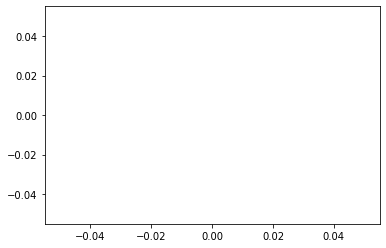

In [0]:
fig = plt.figure()
print(train_costs)
graph1 = plt.plot(iters, train_costs, 'b')
graph2 = plt.plot(iters, test_costs, 'r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


### **2. Plot the accuracy curve**

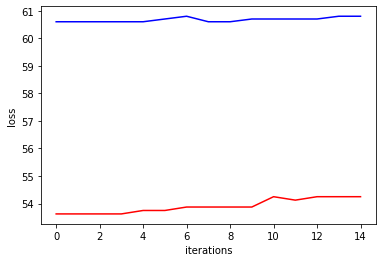

In [0]:
fig = plt.figure()
graph3 = plt.plot(iters, train_accuracys, 'b')
graph4 = plt.plot(iters, test_accuracys, 'r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

### **3. Plot the accuracy value**

In [0]:
final_train_accuracy = train_accuracys[-1]
final_test_accuracy = test_accuracys[-1]
print("final_train_accuracys :", final_train_accuracy,"%")
print("final_test_accuracys :", final_test_accuracy,"%")

final_train_accuracys : 60.79999999999999 %
final_test_accuracys : 54.25 %


### **4. Plot the classification example**

deque([[6, 17, 26, 48, 50, 69, 79, 88, 98, 104]])
17
deque([[0, 1, 2, 3, 4, 5, 7, 8, 9, 10]])


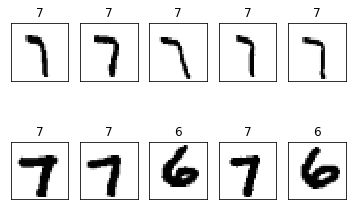

deque([[7, 7, 7, 7, 7, 7, 6, 6, 7, 7]])


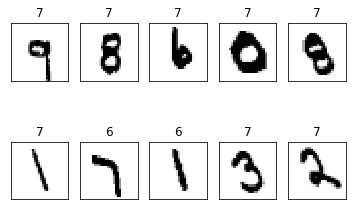

In [0]:
f2 = plt.figure(2)
im_correct  = np.zeros((size_row * size_col, 10), dtype=float)
print(correct_labels)
print(correct_labels[0][1])
print(incorrect_labels)
label_correct_index = []
label_incorrect_index = []

for i in range(10):
    correct_index = correct_labels[0][i]
    im_correct[:, i] += test_image[:, correct_index]
    label_correct_index.append(test_label[correct_index])

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(label_correct_index[i])
    plt.imshow(im_correct[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()
###################################################
print(incorrect_predicts)

f2 = plt.figure(2)
im_incorrect  = np.zeros((size_row * size_col, 10), dtype=float)

for i in range(10):
    incorrect_index = incorrect_labels[0][i]
    im_incorrect[:, i] += test_image[:, incorrect_index]
    label_incorrect_index.append(test_label[incorrect_index])

for i in range(10):
    plt.subplot(2, 5, i+1)
    value = incorrect_predicts[0][i]
    plt.title(value)
    plt.imshow(im_incorrect[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()